In [1]:
from torch.utils.data import DataLoader
# % load_ext autoreload
# % autoreload 2
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# remove scipy
import scipy.misc as sci
import cv2
import re

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Conv1d(1920 * 1080,10 ,(1)),
            nn.Linear(1920 * 1080, 2, bias=True),
            # nn.ReLU(),
            # nn.Linear(10, 10, bias=False),
            # nn.ReLU(),
            # nn.Linear(10, 10, bias=True),
            # nn.ReLU(),
            # nn.Linear(10, 2, bias=False),
            nn.ReLU(),
#             nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = Classifier().to(device)
print(f"Model sent to {device}")

Using cpu device
Model sent to cpu


In [4]:
from create_dataset import ImageDataset, ToTensor

print("Loading image dataset")
image_dataset = ImageDataset(csv_file="./simple_data.csv",
                             root_dir="./bw_images",
                             transform=transforms.Compose([ToTensor()]))
print("Loaded")
print("Loading data from dataset")
loaded = torch.utils.data.DataLoader(image_dataset,
                                     batch_size=1,
                                     shuffle=True,
                                     num_workers=0)
print("Loaded")
print(image_dataset)

Loading image dataset
Loaded
Loading data from dataset
Loaded
        image   is_white   is_black
0   white.ppm          1          0
1   black.ppm          0          1
2   white.ppm          1          0
3   white.ppm          1          0
4   white.ppm          1          0
..        ...        ...        ...
67  black.ppm          0          1
68  black.ppm          0          1
69  black.ppm          0          1
70  black.ppm          0          1
71  black.ppm          0          1

[72 rows x 3 columns]


In [5]:
def train_loop(model, dataloader, loss_fn, optimizer, LOGS=False):
    size = len(loaded)
    end_loss = []
    for batch, obj in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = obj['image']
        labels = obj['landmarks']

        # zero the parameter gradients
        # optimizer.zero_grad()

        # forward + backward + optimize
        prediction = model(inputs)

        # Normalize the probabilities
        predictions_normalized = nn.Softmax(dim=1)(prediction)

        # Find the element with largest probability
        y_pred = predictions_normalized.argmax(1)
    
        # labels = labels.view(predictions_normalized.size(0), 2)
        # prediction = prediction.contiguous().view(1, 1, 2)
#         print(torch.flatten(labels))
        label = torch.from_numpy(np.array([0])) if torch.flatten(labels)[0] == 1 else torch.from_numpy(np.array([1]))
        prediction = nn.Softmax(dim=1)(prediction)
        loss = loss_fn(prediction,label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        end_loss.append(loss.item())
        # Enable or disable logging
        if batch == 10:
            pass
#             return end_loss
        if LOGS:
            loss = loss.item()
            print(f"Predictions {prediction}")
            print(f"Labels {labels}")
            print(f"loss: {loss:>7f}, batch: {batch + 1}/{size}")
    return end_loss

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


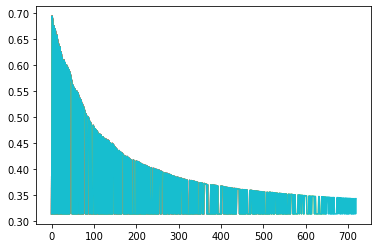

In [6]:
learning_rate = 0.1
# Initialize the loss function
# loss_fn = torch.nn.L1Loss()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 10
i = 0
results = []
for epoch in range(epochs):  # loop over the dataset multiple times
    i += 1
    print(f"Epoch: {i}")
    loss = train_loop(model=model, dataloader=loaded, loss_fn=loss_fn, optimizer=optimizer, LOGS=False)
    results = results + loss
    plt.plot(results)


In [ ]:
PATH = './black_or_white.pth'
if False:
    torch.save(model.state_dict(), PATH)

In [ ]:
net = Classifier()
net.load_state_dict(torch.load(PATH))